In [1]:
import torch
import torch.nn as nn

# Generator

In [2]:
from generator import Generator

# Discriminator

In [3]:
from discriminator import Discriminator

# Training

In [8]:
# Hyperparameters
num_epochs = 50
batch_size = 8
learning_rate = 1e-4

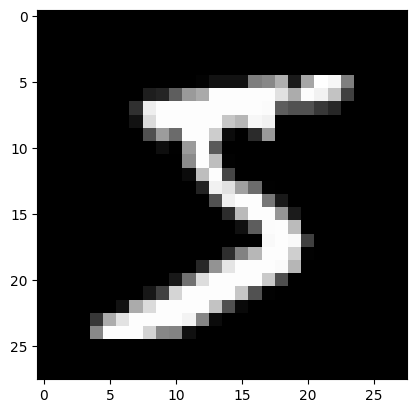

In [9]:
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision import datasets

# First, download the mnist dataset
mnist_dataset = datasets.MNIST(
    'data', 
    train=True, 
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)

# Display an image
plt.imshow(mnist_dataset[0][0].squeeze(), cmap='gray')
plt.show()


In [10]:
import os
import time

def save_generated_images(generator, num_images, device, output_path: str):
    """
    Saves a batch of example images generated by the generator in a grid.
    """
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, 100).to(device)
        images = generator(noise)

        # Reverse the normalization form [-1, 1] to [0, 1]
        images = (images + 1) / 2

        # Convert the tensor to a numpy array in the range with shape (3, 32, 32)
        images = images.cpu().detach().numpy().transpose(0, 2, 3, 1)
        
        plt.figure(figsize=(10, 10))
        for i in range(num_images):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i], cmap='gray')
            plt.axis('off')

        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        plt.savefig(output_path)
        

Using device: cuda
Discriminator loss: 0.7536767721176147
Generator loss: 0.6407346129417419
Discriminator loss: 0.947257399559021
Generator loss: 0.4635791778564453
Discriminator loss: 1.0412421226501465
Generator loss: 0.4073205888271332
Discriminator loss: 1.1211615800857544
Generator loss: 0.3738674521446228
Discriminator loss: 1.170782446861267
Generator loss: 0.3610646724700928
Discriminator loss: 1.1916444301605225
Generator loss: 0.35272109508514404
Discriminator loss: 1.2335553169250488
Generator loss: 0.3456396460533142
Discriminator loss: 1.2921565771102905
Generator loss: 0.33461853861808777
Discriminator loss: 1.254511833190918
Generator loss: 0.3389962315559387
Discriminator loss: 1.2883219718933105
Generator loss: 0.33744508028030396
Discriminator loss: 1.2737538814544678
Generator loss: 0.33372968435287476
Discriminator loss: 1.2883555889129639
Generator loss: 0.3334551751613617
Discriminator loss: 1.312734842300415
Generator loss: 0.33116793632507324
Discriminator loss

KeyboardInterrupt: 

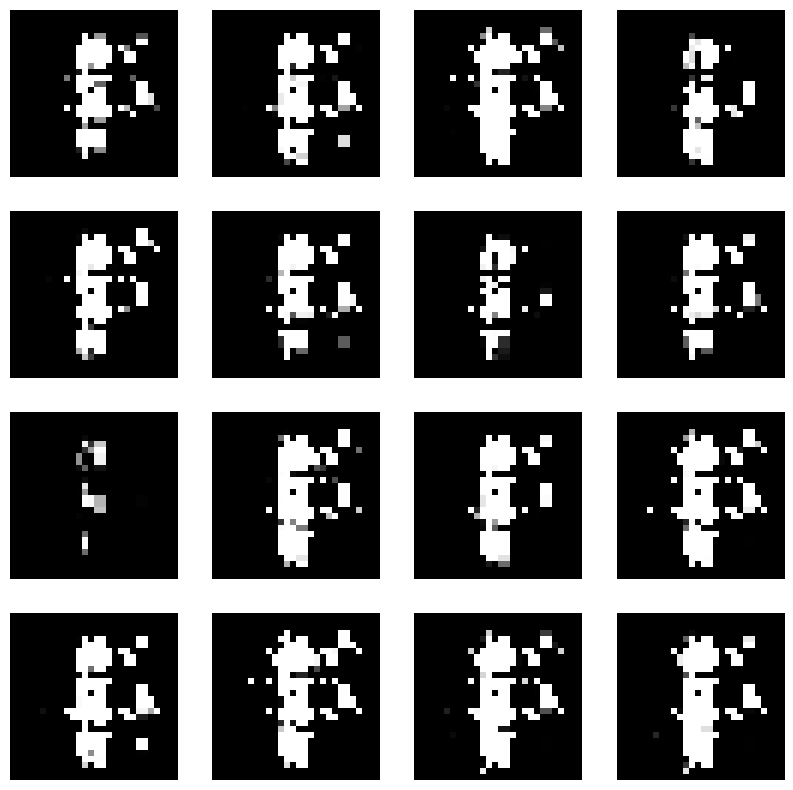

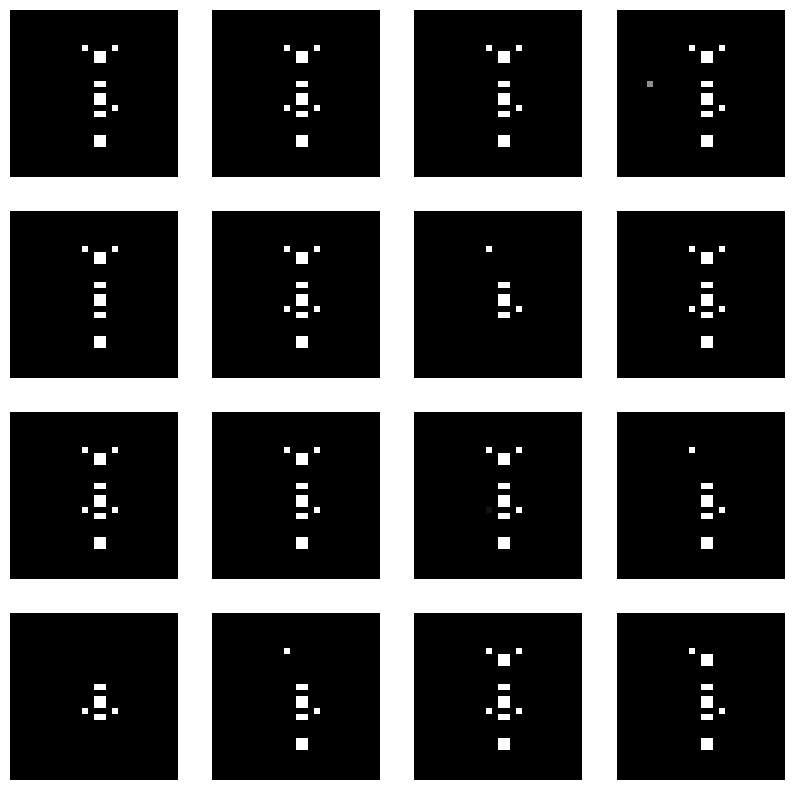

In [11]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Hyperparameters
num_channels = 1
noise_dim = 100
image_dim = 28

# Initialize the generator and discriminator
generator = Generator(num_channels, noise_dim, image_dim).to(device)
discriminator = Discriminator(num_channels, image_dim).to(device)

# Define train loader
train_loader = torch.utils.data.DataLoader(
    mnist_dataset,
    batch_size=batch_size,
    shuffle=True,
)

# Define optimizers
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=1e-5)

# Define the loss function
criterion = nn.BCELoss().to(device)


# TODO: Try this if needed
# Use different loss calculation for generator
# def generator_loss(fake_output, valid):
    # return -torch.mean(torch.log(fake_output + 1e-8))  # Minimize negative log likelihood


# Training loop
# get current time
start_time = time.strftime("%Y-%m-%d_%H-%M-%S")
for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move the data to the device
        data = data.to(device)
        current_batch_size = data.shape[0]

        # Define the valid and fake labels
        # valid = torch.ones(current_batch_size, 1).to(device) # The discriminator should output 1 for real data
        # fake = torch.zeros(current_batch_size, 1).to(device) # The discriminator should output 0 for fake data
        # Label smoothing
        valid = torch.ones(current_batch_size, 1).to(device) * 0.9 # The discriminator should output 1 for real data
        fake = torch.zeros(current_batch_size, 1).to(device) * 0.1 # The discriminator should output 0 for fake data

        # Generate a batch of noise vectors for the generator
        noise_vector = torch.randn(current_batch_size, 100).to(device) 

        ### Train the Generator ###
        optimizer_generator.zero_grad()

        # Generate a batch of fake images
        generated_images = generator(noise_vector)

        # See how well the discriminator thinks the generated images are real
        gen_loss = criterion(discriminator(generated_images), valid)

        # Backpropagate the generator loss
        gen_loss.backward()
        optimizer_generator.step()

        ############################################################

        ### Train the Discriminator ###
        optimizer_discriminator.zero_grad()

        # Get the discriminator's prediction on the real data
        real_pred = discriminator(data)
        real_loss = criterion(real_pred, valid)

        # Get the discriminator's prediction on the fake data
        fake_pred = discriminator(generated_images.detach())
        fake_loss = criterion(fake_pred, fake)

        # Combine the losses
        combined_loss = (real_loss + fake_loss) / 2

        # Backpropagate the combined loss
        combined_loss.backward()
        optimizer_discriminator.step()

        print(f"Discriminator loss: {combined_loss.item()}")
        print(f"Generator loss: {gen_loss.item()}")

    # Save a sample of the generated images
    output_path = f"logs/{start_time}/generated_image_{epoch}.png"
    save_generated_images(generator, 16, device, output_path)
